In [1]:
#import
import pandas as pd
import numpy as np
import seaborn as sns
import os
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, BatchNormalization
from keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

2025-05-28 13:20:28.647753: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748438428.889199      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748438428.953512      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


**LoadData**

In [2]:
#
images = []
ages = []

for i in os.listdir('/kaggle/input/face-utk/Face_Detection/Face_Detection'):
    split = i.split('_')
    ages.append(int(split[0]))

    images.append(Image.open('/kaggle/input/face-utk/Face_Detection/Face_Detection/' + i))

In [3]:
images = pd.Series(list(images), name = 'Images')
ages = pd.Series(list(ages), name = 'Ages')

df = pd.concat([images, ages], axis=1)
df

,Images,Ages
0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,26
1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,21
2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,17
3,<PIL.JpegImagePlugin.JpegImageFile image mode=...,76
4,<PIL.JpegImagePlugin.JpegImageFile image mode=...,18
...,...,...
7995,<PIL.JpegImagePlugin.JpegImageFile image mode=...,3
7996,<PIL.JpegImagePlugin.JpegImageFile image mode=...,28
7997,<PIL.JpegImagePlugin.JpegImageFile image mode=...,10
7998,<PIL.JpegImagePlugin.JpegImageFile image mode=...,8


/tmp/ipykernel_35/1271551252.py:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Ages'],kde=True, bins=30)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Ages', ylabel='Density'>

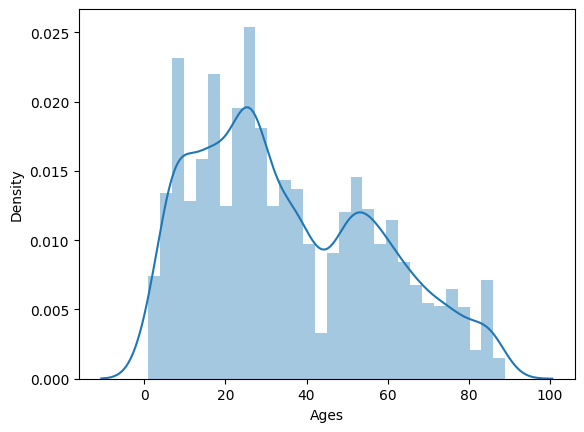

In [19]:
# chỉ đưa vào 1/3 số tuổi từ 0 đến 4 vì ở tuổi này có quá nhiều
under4s = []

for i in range(len(df)):
    if df['Ages'].iloc[i] <= 4:
        under4s.append(df.iloc[i])
under4s = pd.DataFrame(under4s)
under4s = under4s.sample(frac=0.3)

df = df[df['Ages'] > 4]

df = pd.concat([df, under4s], ignore_index = True)
sns.distplot(df['Ages'],kde=True, bins=30)

/tmp/ipykernel_35/3630449536.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Ages'],kde=True, bins=20)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Ages', ylabel='Density'>

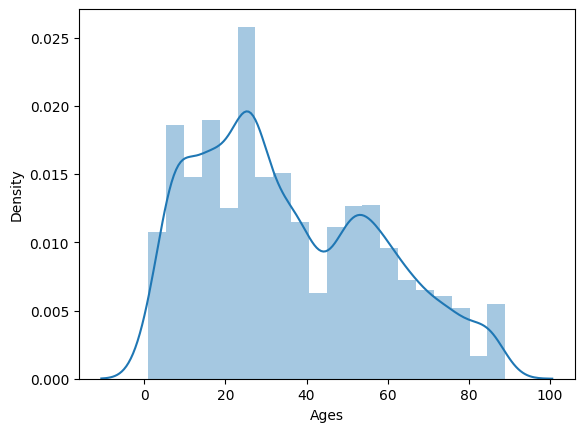

In [20]:
# loại bỏ tuổi từ 99 trở đi vì có ít dữ liệu
df = df[df['Ages'] < 99]
sns.distplot(df['Ages'],kde=True, bins=20)

In [21]:
x = []
y = []

for _, row in df.iterrows():
    # Resize ảnh
    img_resized = row['Images'].resize((200, 200), Image.Resampling.LANCZOS)
    # Chuyển sang array
    img_array = np.asarray(img_resized)
    x.append(img_array)

    # Lưu nhãn
    age = int(row['Ages'])
    y.append([age])

x = np.array(x)
y = np.array(y)

**Train test split**

In [22]:
y_age = df['Ages']

x_train_age, x_test_age, y_train_age, y_test_age = train_test_split(x, y_age, test_size=0.2, stratify=y_age)

In [24]:
agemodel = Sequential()
agemodel.add(Conv2D(32, (3,3), activation='relu', input_shape=(200, 200, 3)))
agemodel.add(MaxPooling2D((2,2)))
agemodel.add(Conv2D(64, (3,3), activation='relu'))
agemodel.add(MaxPooling2D((2,2)))
agemodel.add(Conv2D(128, (3,3), activation='relu'))
agemodel.add(MaxPooling2D((2,2)))
agemodel.add(Flatten())
agemodel.add(Dense(64, activation='relu'))
agemodel.add(Dropout(0.5))
agemodel.add(Dense(1, activation='relu'))

agemodel.compile(
    loss='mean_squared_error',
    optimizer=optimizers.Adam(learning_rate=0.0001),
    metrics=['mae']
)

**Training**

In [25]:
datagen = ImageDataGenerator(
      rescale=1./255., width_shift_range = 0.1, height_shift_range = 0.1, horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale=1./255)

train2 = datagen.flow(x_train_age, y_train_age, batch_size=32)

test2 = test_datagen.flow(
        x_test_age, y_test_age,
        batch_size=32)

history1 = agemodel.fit(train2, epochs=100, shuffle=True, validation_data=test2)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100


I0000 00:00:1748438942.165117     106 service.cc:148] XLA service 0x792b600046f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748438942.166095     106 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1748438942.166118     106 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1748438942.485514     106 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/159 ━━━━━━━━━━━━━━━━━━━━ 18:56 7s/step - loss: 1314.5188 - mae: 31.5328

I0000 00:00:1748438946.930562     106 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


159/159 ━━━━━━━━━━━━━━━━━━━━ 49s 266ms/step - loss: 802.9945 - mae: 22.6141 - val_loss: 547.9903 - val_mae: 18.9059
Epoch 2/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 39s 247ms/step - loss: 583.6061 - mae: 19.6998 - val_loss: 498.3805 - val_mae: 18.0095
Epoch 3/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 39s 245ms/step - loss: 527.4341 - mae: 18.5774 - val_loss: 408.5550 - val_mae: 16.2669
Epoch 4/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 39s 244ms/step - loss: 459.0976 - mae: 16.9883 - val_loss: 371.3929 - val_mae: 15.3109
Epoch 5/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 39s 245ms/step - loss: 435.6403 - mae: 16.6416 - val_loss: 333.0094 - val_mae: 14.7964
Epoch 6/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 39s 247ms/step - loss: 413.5049 - mae: 16.2844 - val_loss: 344.5432 - val_mae: 14.4459
Epoch 7/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 39s 246ms/step - loss: 403.9303 - mae: 15.8547 - val_loss: 317.7944 - val_mae: 14.3937
Epoch 8/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 39s 246ms/step - loss: 418.7714 - mae: 16.1869 - val_loss: 300.2917 - val_m

In [26]:
agemodel.save('/kaggle/working/agemodel.h5')

In [27]:
from IPython.display import FileLink

FileLink('agemodel.h5')

/kaggle/working/agemodel.h5

**Evaluating the Models**

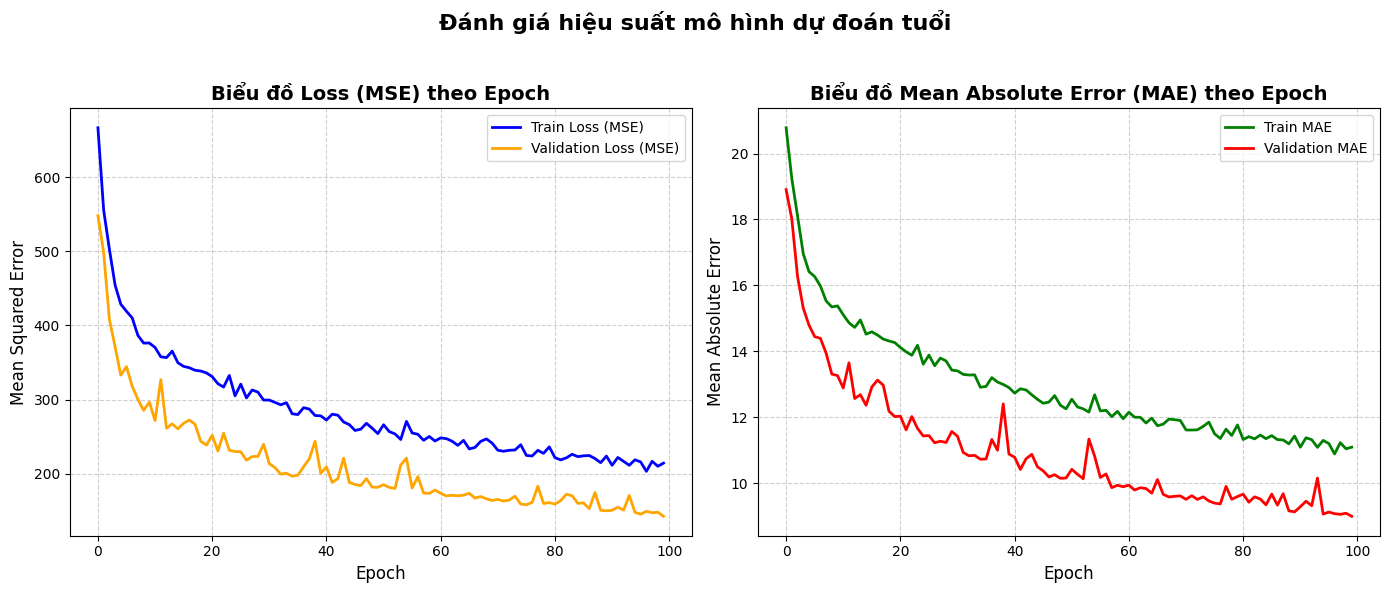

In [28]:
from matplotlib import pyplot as plt

plt.figure(figsize=(14,6))

# Biểu đồ Loss (Mean Squared Error)
plt.subplot(1, 2, 1)
plt.plot(history1.history['loss'], label='Train Loss (MSE)', color='blue', linewidth=2)
plt.plot(history1.history['val_loss'], label='Validation Loss (MSE)', color='orange', linewidth=2)
plt.title('Biểu đồ Loss (MSE) theo Epoch', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Mean Squared Error', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.6)

# Biểu đồ MAE (Mean Absolute Error)
plt.subplot(1, 2, 2)
plt.plot(history1.history['mae'], label='Train MAE', color='green', linewidth=2)
plt.plot(history1.history['val_mae'], label='Validation MAE', color='red', linewidth=2)
plt.title('Biểu đồ Mean Absolute Error (MAE) theo Epoch', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Mean Absolute Error', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.6)

plt.suptitle('Đánh giá hiệu suất mô hình dự đoán tuổi', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
MAE: 8.99
RMSE: 11.95
R² score: 0.71


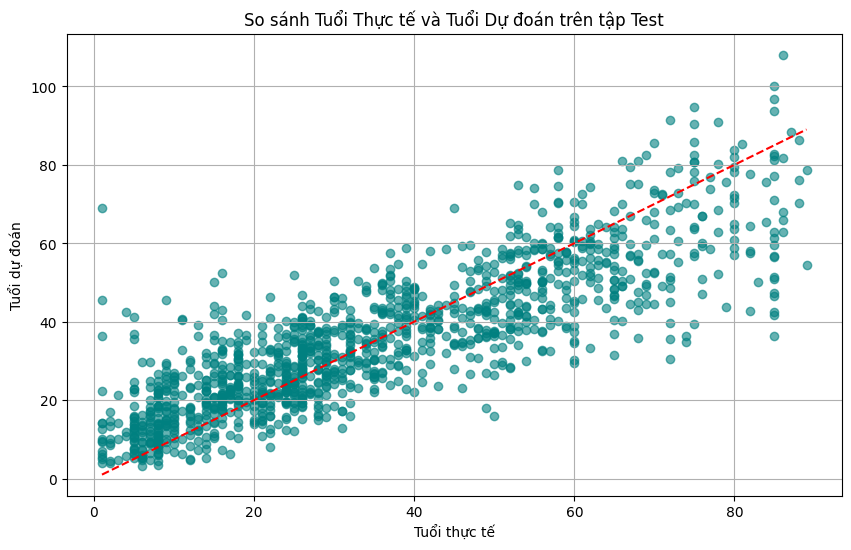

In [31]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

x_test_norm = x_test_age / 255.0
y_pred_age = agemodel.predict(x_test_norm).reshape(-1)
y_test_real = y_test_age.values.reshape(-1)

mae = mean_absolute_error(y_test_real, y_pred_age)
rmse = np.sqrt(mean_squared_error(y_test_real, y_pred_age))
r2 = r2_score(y_test_real, y_pred_age)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² score: {r2:.2f}")

plt.figure(figsize=(10,6))
plt.scatter(y_test_real, y_pred_age, alpha=0.6, color='teal')
plt.plot([y_test_real.min(), y_test_real.max()], [y_test_real.min(), y_test_real.max()], 'r--')
plt.xlabel('Tuổi thực tế')
plt.ylabel('Tuổi dự đoán')
plt.title('So sánh Tuổi Thực tế và Tuổi Dự đoán trên tập Test')
plt.grid(True)
plt.show()